<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/Sklearn_Online_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scikit Learn

### Hogyan használjuk az incremental learninget helyesen

Az eredeti cikk forássa az alábbi címen található:

https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-incremental-learning-for-large-datasets

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, Y = datasets.make_regression(n_samples=240000, random_state=123)

print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)

X.shape =  (240000, 100)
Y.shape =  (240000,)


In [2]:
print('X.nbytes = ', X.nbytes//1024, 'Kbyte')
print('X.nbytes = ', X.nbytes//1024//1024, 'Mbyte')

X.nbytes =  187500 Kbyte
X.nbytes =  183 Mbyte


In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=123)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((216000, 100), (24000, 100), (216000,), (24000,))

### Na erre az átalakításra kíváncsi vagyok

In [4]:
X_train, X_test = X_train.reshape(-1,24,100), X_test.reshape(-1,24,100)
Y_train, Y_test = Y_train.reshape(-1,24), Y_test.reshape(-1,24)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9000, 24, 100), (1000, 24, 100), (9000, 24), (1000, 24))

Ilyen átalakítást korábban még nem láttam, de nagyon érdekes.

In [5]:
X_train[0].shape, Y_train[0].shape

((24, 100), (24,))

Ha jól értem az `X_train` és az `Y_train`, batcheket, kics adatcsomagokat tartalmaz.

Valahogy úgy, hogy `X_train[0]` az például egy adatcsomag.



### Create and Train Model

In this section, we have created an ML model using `SGDRegressor` class of scikit-learn. We have then looped through data in **batches** and trained this estimator by calling `partial_fit()` method on it for each batch of data. We have also looped through total data **10 times** where each time training will be performed in batches.

Tehát ha jól értem.:

24 méretű batcheket (csomagokat) magyarul a **batch_size** lehetne 24 és 10-szer vagyis az **epoch** lehetne 10, a hagyományos terminológiában.

In [13]:
from sklearn.linear_model import SGDRegressor

regressor = SGDRegressor()

epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]
        regressor.partial_fit(X_batch, Y_batch)       ## Partially fitting data in batches

Az SGDRegressor konstruktorában sok minden van, de ami engem érdekel a fenti vizsgálat szempontjából az a következőek.

```
SGDRegressor(max_iter=1000,
             shuffle=True,
             verbose=0,
             random_state=None,
             learning_rate='invscaling',
             validation_fraction=0.1,
             warm_start=False)
```

1. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.



### Evaluate Model Performance on Test Data

In this section, we have evaluated the performance of our trained model on test data. We have looped through test data in batches and made predictions on them. We have then combined the prediction of each batch.

Na ez is nagyon érdkes:

Én simán ráhívtam volna az egész adatra a `predict` függvényt.

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = regressor.predict(X_test[j])
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.00024876312858854676
Test R2 Score : 0.9999999907249083
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


Hát igen, úgy látom ez a szakszerű módja annak, hogy elvégezzük a becslést, hiszen az `Y_train` és az `Y_test` adatok is batch kötegebe vannak formálva. És értelemszerűen ha ilyen formában tanítottuk a modelt akkor ilyen formában kell csinálnunk a becslést is, hiszen mást nem tudna megenni a model.

In [20]:
print('Y_train.shape = ', Y_train.shape)
print('Y_test.shape  = ', Y_test.shape)

Y_train.shape =  (9000, 24)
Y_test.shape  =  (1000, 24)


### Evaluate Model Performance on Train Data

At last, we have calculated MSE and R^2 scores on the training dataset to check the performance of the model on train data.

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

Y_train_preds = []
for j in range(X_train.shape[0]): ## Looping through train batches for making predictions
    Y_preds = regressor.predict(X_train[j])
    Y_train_preds.extend(Y_preds.tolist())

print("Train MSE      : {}".format(mean_squared_error(Y_train.reshape(-1), Y_train_preds)))
print("Train R2 Score : {}".format(r2_score(Y_train.reshape(-1), Y_train_preds)))
print("Y_train.reshape(-1).shape : ", Y_train.reshape(-1).shape)
print("len(Y_train_preds)        :  ", len(Y_train_preds))

Train MSE      : 0.00024853825291878094
Train R2 Score : 0.9999999907225984
Y_train.reshape(-1).shape :  (216000,)
len(Y_train_preds)        :   216000


In [23]:
print('Ennyiszer látta a model az adatokat : ', regressor.t_)

Ennyiszer látta a model az adatokat :  2160001.0


### MLPRegressor

In [32]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler((0, 1))
Y_scaler = MinMaxScaler((0, 1))

X, Y = datasets.make_regression(n_samples=240000, random_state=123)

print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)

print('X.nbytes = ', X.nbytes//1024, 'Kbyte')
print('X.nbytes = ', X.nbytes//1024//1024, 'Mbyte')

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=123)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


X_train_scaled = X_scaler.fit_transform(X_train)
Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1, 1)).flatten()

X_test_scaled  = X_scaler.transform(X_test)
Y_test_scaled  = Y_scaler.transform(Y_test.reshape(-1, 1)).flatten()

print(X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape)


X.shape =  (240000, 100)
Y.shape =  (240000,)
X.nbytes =  187500 Kbyte
X.nbytes =  183 Mbyte
(216000, 100) (24000, 100) (216000,) (24000,)
(216000, 100) (24000, 100) (216000,) (24000,)


### Na erre az átalakításra kíváncsi vagyok

In [33]:
X_train, X_test = X_train_scaled.reshape(-1,24,100), X_test_scaled.reshape(-1,24,100)
Y_train, Y_test = Y_train_scaled.reshape(-1,24), Y_test_scaled.reshape(-1,24)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9000, 24, 100), (1000, 24, 100), (9000, 24), (1000, 24))

Ilyen átalakítást korábban még nem láttam, de nagyon érdekes.

In [34]:
X_train[0].shape, Y_train[0].shape

((24, 100), (24,))

Ha jól értem az `X_train` és az `Y_train`, batcheket, kics adatcsomagokat tartalmaz.

Valahogy úgy, hogy `X_train[0]` az például egy adatcsomag.



### Create and Train Model

In this section, we have created an ML model using `MLPRegressor` class of scikit-learn. We have then looped through data in **batches** and trained this estimator by calling `partial_fit()` method on it for each batch of data. We have also looped through total data **10 times** where each time training will be performed in batches.

Tehát ha jól értem.:

24 méretű batcheket (csomagokat) magyarul a **batch_size** lehetne 24 és 10-szer vagyis az **epoch** lehetne 10, a hagyományos terminológiában.

### [ ! ]

Itt viszont lesz egy fundamentális különbség az `SGDRegressor` osztályhoz képest.

Ott ugyanis nem volt megadható a `batch_size` az `MLPRegreessor` esetében igen.

1. Probáljuk meg úgy, hogy az összes adatot ami a köteben szerepel megkapja
2. Próbáljuk meg úgy, hogy csak egy adatot kap meg beállításként.
3. Nézzük meg milyen eredményt ad a `warm_start` bekapcsolása, van-e hatása
4. Nézzük meg, hogy van-e különbség a `fit` és `partial_fit` között.
5. Tudomásom szerint `partial_fit` esetén nincs hatása a `max_iter` értékének, de tesztelni kell. (Hamis)

### [ 1 ]

Az első kísérlet.

In [36]:
from sklearn.neural_network import MLPRegressor

mlp1 = MLPRegressor(hidden_layer_sizes=(10, ),
                    activation='relu',
                    solver='sgd',
                    batch_size=24,
                    max_iter=1,
                    learning_rate_init=0.001,
                    shuffle=True,
                    verbose=False,
                    random_state=123,
                    validation_fraction=0.0,
                    n_iter_no_change=98765)

1. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.

In [37]:
epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]     ## (24, 100) és (24,)
        mlp1.partial_fit(X_batch, Y_batch)            ## Partially fitting data in batches

### [ 1 ] Evaluate Model Performance on Test Data


In [41]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = mlp1.predict(X_test[j])
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.00025005242167357546
Test R2 Score : 0.981430351001458
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


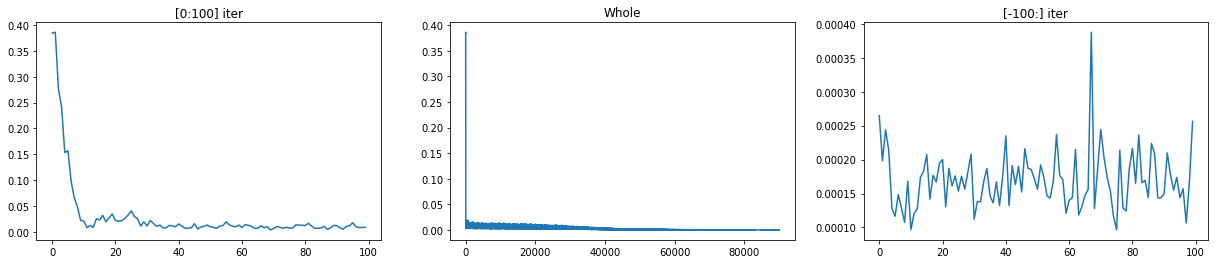

mlp1.t_       :   2160000
Y_train.shape :  (9000, 24)


In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))
ax1.plot(mlp1.loss_curve_[0:100])
ax1.set_title('[0:100] iter')
ax2.plot(mlp1.loss_curve_)
ax2.set_title('Whole')
ax3.plot(mlp1.loss_curve_[-100:])
ax3.set_title('[-100:] iter')
plt.show()
print("mlp1.t_       :  ", mlp1.t_)
print("Y_train.shape : ", Y_train.shape)

### [ 2 ]

A második kísérlet.

In [46]:
from sklearn.neural_network import MLPRegressor

mlp2 = MLPRegressor(hidden_layer_sizes=(10, ),      # mlp2
                    activation='relu',
                    solver='sgd',
                    batch_size=1,           # 24 -> 1
                    max_iter=1,
                    learning_rate_init=0.001,
                    shuffle=True,
                    verbose=False,
                    random_state=123,
                    validation_fraction=0.0,
                    n_iter_no_change=98765)

2. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.

In [47]:
epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]     ## (24, 100) és (24,)
        mlp2.partial_fit(X_batch, Y_batch)            ## Partially fitting data in batches

### [ 2 ] Evaluate Model Performance on Test Data

In [48]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = mlp2.predict(X_test[j])             ## mlp2
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 7.763068047566436e-07
Test R2 Score : 0.9999423491091067
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


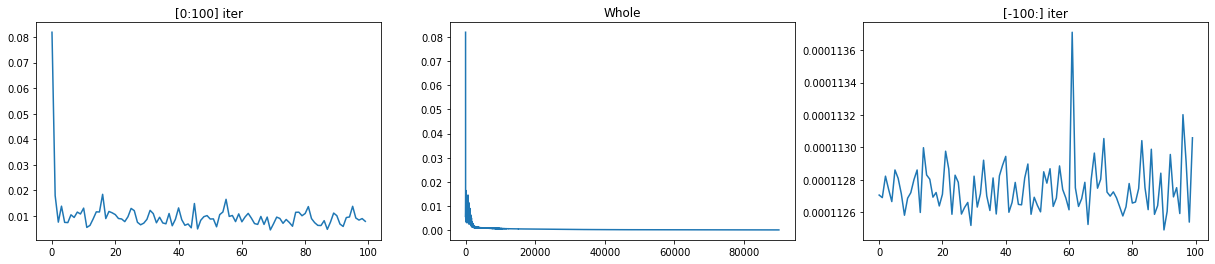

mlp2.t_       :   2160000
Y_train.shape :  (9000, 24)


In [49]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))
ax1.plot(mlp2.loss_curve_[0:100])
ax1.set_title('[0:100] iter')
ax2.plot(mlp2.loss_curve_)
ax2.set_title('Whole')
ax3.plot(mlp2.loss_curve_[-100:])
ax3.set_title('[-100:] iter')
plt.show()
print("mlp2.t_       :  ", mlp2.t_)
print("Y_train.shape : ", Y_train.shape)

### Megtapasztalás

A tapasztalat itt a következő.

Igaz ugyan, hogy összességében ugyan annyiszor látta minkét model az adatokat.

De alapvető különbségek vannak.

1. Ha a batch_size = 24 akkor a hibát a 24 adaton méri és úgy modosítja a súlyokat
2. Ha a batch_size = 1 akkor a hibát 1-adatra méri (akkor is ha a csomagban 24 van). Végig megy minden adaton, mindegyikre egyenként megméri a hibát, és minden körben modosít egyet. Érdekes módon a loss értéket csak akkor adja a historyhoz ha végig ment mind a 24 adaton és tovább lép a következő csomagra.

Ezért fordulhat elő, hogy a loss_curve lista hossza ugyan akkorra mindkét esetben.

Egyszóval a batch_size értékének még ilyen esetben is van jelentősége.

Bár az is igaz, hogy efölött kontrolt tudok gyakorolni úgy is, hogy mekkora kötegeket gyártok le az elején. Ha ott 1-re veszem a köteg méretét akkor elvileg ugyan ezt az erdményt kapom.

### [ 3 ]

A harmadik kísérlet.

In [51]:
from sklearn.neural_network import MLPRegressor

mlp3 = MLPRegressor(hidden_layer_sizes=(10, ),      # mlp3
                    activation='relu',
                    solver='sgd',
                    batch_size=24,
                    max_iter=1,
                    warm_start=True,        # False -> True
                    learning_rate_init=0.001,
                    shuffle=True,
                    verbose=False,
                    random_state=123,
                    validation_fraction=0.0,
                    n_iter_no_change=98765)

1. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.

In [52]:
epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]     ## (24, 100) és (24,)
        mlp3.partial_fit(X_batch, Y_batch)            ## Partially fitting data in batches

### [ 3 ] Evaluate Model Performance on Test Data

In [53]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = mlp3.predict(X_test[j])             ## mlp3
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.00025005242167357546
Test R2 Score : 0.981430351001458
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


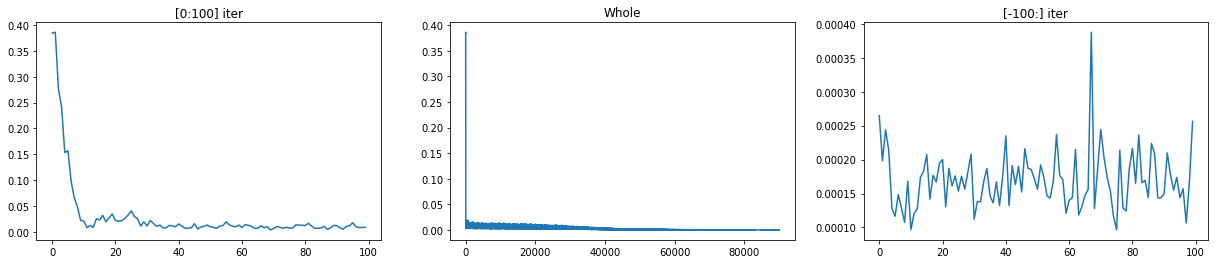

mlp3.t_       :   2160000
Y_train.shape :  (9000, 24)


In [54]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))
ax1.plot(mlp3.loss_curve_[0:100])
ax1.set_title('[0:100] iter')
ax2.plot(mlp3.loss_curve_)
ax2.set_title('Whole')
ax3.plot(mlp3.loss_curve_[-100:])
ax3.set_title('[-100:] iter')
plt.show()
print("mlp3.t_       :  ", mlp3.t_)
print("Y_train.shape : ", Y_train.shape)

### Megtapasztalás

Na ez az az eset amikor a `warm_start` beállításának semmilyen hatása nincsen gondolom a `partial_fit` hívás nem veszi figyelembe ezt az értéket.

Az ereddmény azonos az \[1\] kísérletben mért eredménnyel.

### [ 4 ]

A negyedik kísérlet.

In [55]:
from sklearn.neural_network import MLPRegressor

mlp4 = MLPRegressor(hidden_layer_sizes=(10, ),      # mlp4
                    activation='relu',
                    solver='sgd',
                    batch_size=24,
                    max_iter=1,
                    learning_rate_init=0.001,
                    shuffle=True,
                    verbose=False,
                    random_state=123,
                    validation_fraction=0.0,
                    n_iter_no_change=98765)

1. `max_iter` akkor most az van, hogy mind a **24** mintán amiből van **9000** és **10-szer** végig megy, azon hol végizi el ezt a `max_iter=1000` lépést? Vagy mivel a `partial_fit` metodust hívjuk meg ez az érték deffinició szerűen nem játszik és olyan mintha az értéke 1 lenne? Erre gondolok, szerintem ez a helyzet.

In [ ]:
epochs = 10

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]     ## (24, 100) és (24,)
        mlp4.fit(X_batch, Y_batch)                    ## Partially fitting data in batches      ## partial_fit -> fit

### [ 4 ] Evaluate Model Performance on Test Data

In [57]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = mlp4.predict(X_test[j])             ## mlp4
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.7217442371565003
Test R2 Score : -52.59890962468918
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


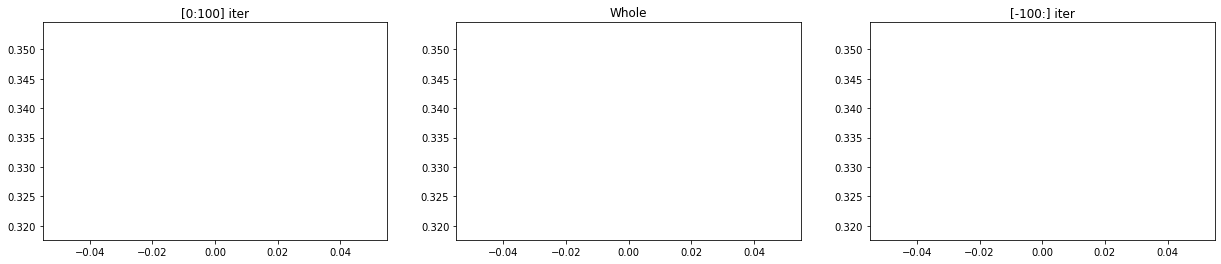

mlp4.t_       :   24
Y_train.shape :  (9000, 24)


In [58]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))
ax1.plot(mlp4.loss_curve_[0:100])
ax1.set_title('[0:100] iter')
ax2.plot(mlp4.loss_curve_)
ax2.set_title('Whole')
ax3.plot(mlp4.loss_curve_[-100:])
ax3.set_title('[-100:] iter')
plt.show()
print("mlp4.t_       :  ", mlp4.t_)
print("Y_train.shape : ", Y_train.shape)

### Megtapasztalás

Nos elöször is ez nem működik, azt a vak is látja.

Tanítás során folyamatosan

```
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696:
ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
```

Ez szar ügy.

Azt hittem, hogy ennek ellenére valamit azért csak össze tud okoskodni, de nem.


### [ 5 ]

Az ötödik kísérlet.

In [99]:
from sklearn.neural_network import MLPRegressor

mlpX = MLPRegressor(hidden_layer_sizes=(10, ),      # mlpX
                    activation='relu',
                    solver='sgd',
                    batch_size=1,
                    max_iter=1,
                    warm_start=True,        # False -> True 
                    learning_rate_init=0.001,
                    shuffle=True,
                    verbose=False,
                    random_state=123,
                    validation_fraction=0.0,
                    n_iter_no_change=98765)

epochs = 1

for k in range(epochs):                               ## Number of loops through data
    for i in range(X_train.shape[0]):                 ## Looping through batches (9000)
        X_batch, Y_batch = X_train[i], Y_train[i]     ## (24, 100) és (24,)
        mlpX.fit(X_batch, Y_batch)                    ## Partially fitting data in batches      ## partial_fit -> fit

In [100]:
from sklearn.metrics import mean_squared_error, r2_score

Y_test_preds = []
for j in range(X_test.shape[0]):                  ## Looping through test batches for making predictions
    Y_preds = mlpX.predict(X_test[j])             ## mlpX
    Y_test_preds.extend(Y_preds.tolist())

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))
print("Y_test.reshape(-1).shape : ", Y_test.reshape(-1).shape)
print("len(Y_test_preds)        :  ", len(Y_test_preds))

Test MSE      : 0.00011413916684733072
Test R2 Score : 0.9915236803100919
Y_test.reshape(-1).shape :  (24000,)
len(Y_test_preds)        :   24000


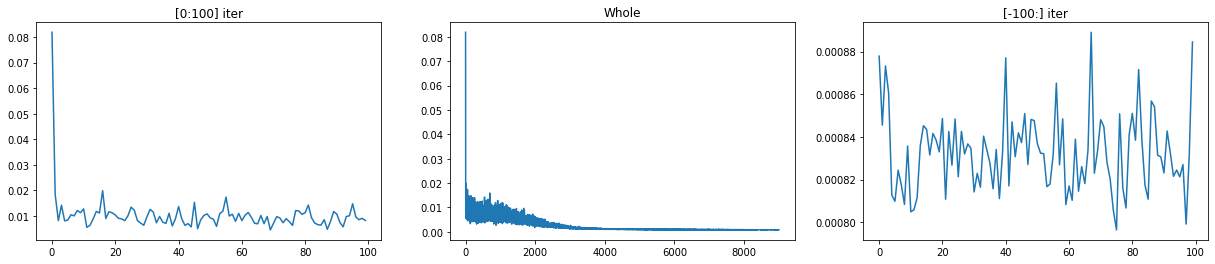

mlpX.t_       :   216000
Y_train.shape :  (9000, 24)


In [101]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 4))
ax1.plot(mlpX.loss_curve_[0:100])
ax1.set_title('[0:100] iter')
ax2.plot(mlpX.loss_curve_)
ax2.set_title('Whole')
ax3.plot(mlpX.loss_curve_[-100:])
ax3.set_title('[-100:] iter')
plt.show()
print("mlpX.t_       :  ", mlpX.t_)
print("Y_train.shape : ", Y_train.shape)

Egy nagyon jó magyarázat és tényleg ez a lényeg



```
If warm_start = False, each subsequent call to .fit() (after an initial call to .fit() or
partial_fit()) will reset the model's trainable parameters for the initialisation. If warm_start =
True, each subsequent call to .fit() (after an initial call to .fit() or partial_fit()) will retain
the values of the model's trainable parameters from the previous run, and use those initially.
Regardless of the value of warm_start, each call to partial_fit() will retain the previous run's
model parameters and use those initially.
```
Ebből kifolyólag a partial_fit mindíg jobb eredményt fog adni, mert két hívás között nem inicializálja újra a súlyokat, a fit viszont igen.

A fenti pédában mi pedig 9000 alkalommal hívtuk meg a fit függvényt, tök mindegy, hogy a `batch_size = 1`, vagy `24`, 9000 alkalommal meghívtuk és minden alaklaommal újra inicializált súlyokkal dolgozott, míg a `partial_fit` az elöző alkalomból származó súlyokkal dolgozott.

Ezért konvergál jobban.


Az egy más kérdés, hogy `fit -> warm_start -> max_iter =1` esetén a `batch_size = 1` vagy a `24` ad jobb eredményt, mindkettő elmarat a `partial_fit` mögött.

Ha a `batch_size` nagy (fent a 24 a teljes köteget jelenti) igazából kevessebbszer módosítja a súlyokat, mert csak akkor modosít ha a teljes kötegre kiszámolta a hibát, `batch_size = 1` esetén pedig minden egyes elem után modosít egyet. Vagyis itt egy köteg esetén 24-szer modosít, tehát sokkal többször tanul.


In [98]:
import sklearn.neural_network
import numpy as np
import warnings
warnings.simplefilter('ignore')
np.random.seed(0)
x = np.linspace(-1, 1, num=50).reshape(-1, 1)
y = (x * 1.5 + 2).reshape(50,)
cold_model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(), warm_start=False, max_iter=1)
warm_model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(), warm_start=True, max_iter=1)

cold_model.fit(x,y)
print('cold_model ', cold_model.coefs_, cold_model.intercepts_)
#[array([[0.17009494]])] [array([0.74643783])]
cold_model.fit(x,y)
print('cold_model ',cold_model.coefs_, cold_model.intercepts_)
#[array([[-0.60819342]])] [array([-1.21256186])]
#after second run of .fit(), values are completely different
#because they were re-initialised before doing the second run for the cold model

warm_model.fit(x,y)
print('warm_model ', warm_model.coefs_, warm_model.intercepts_)
#[array([[-1.39815616]])] [array([1.651504])]
warm_model.fit(x,y)
print('warm_model ', warm_model.coefs_, warm_model.intercepts_)
#[array([[-1.39715616]])] [array([1.652504])]
#this time with the warm model, params change relatively little, as params were
#not re-initialised during second call to .fit()

cold_model.partial_fit(x,y)
print('cold_model ',cold_model.coefs_, cold_model.intercepts_)
#[array([[-0.60719343]])] [array([-1.21156187])]
cold_model.partial_fit(x,y)
print('cold_model ',cold_model.coefs_, cold_model.intercepts_)
#[array([[-0.60619347]])] [array([-1.21056189])]
#with partial_fit(), params barely change even for cold model,
#as no re-initialisation occurs

warm_model.partial_fit(x,y)
print('warm_model ', warm_model.coefs_, warm_model.intercepts_)
#[array([[-1.39615617]])] [array([1.65350392])]
warm_model.partial_fit(x,y)
print('warm_model ', warm_model.coefs_, warm_model.intercepts_)
#[array([[-1.39515619]])] [array([1.65450372])]
#and of course the same goes for the warm model

cold_model  [array([[0.17009494]])] [array([0.74643783])]
cold_model  [array([[-0.60819342]])] [array([-1.21256186])]
warm_model  [array([[-1.39815616]])] [array([1.651504])]
warm_model  [array([[-1.39715616]])] [array([1.652504])]
cold_model  [array([[-0.60719343]])] [array([-1.21156187])]
cold_model  [array([[-0.60619347]])] [array([-1.21056189])]
warm_model  [array([[-1.39615617]])] [array([1.65350392])]
warm_model  [array([[-1.39515619]])] [array([1.65450372])]


### Vége

Ezzel pontot is tettünk az egészre és megértettük, hogy mi a különbség a fit és partial_fit között.

warm_start = False esetén a fit nem a korábbi futás során kialakult súlyokat használja, hanem újakat inicializál.

Ha viszont a 1. `warm_stat = True`, 2. a `batch_size = 1` és 3. a `max_iter = 1` akkor a két metodus azonos eredményt ad.

### Kiegészítés

Normalizáció a fentihez hasonló kötegeken.

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

X, Y = datasets.make_regression(n_samples=240000, random_state=123)

print('X.shape = ', X.shape)
print('Y.shape = ', Y.shape)

X.shape =  (240000, 100)
Y.shape =  (240000,)


In [7]:
print('X.nbytes = ', X.nbytes//1024, 'Kbyte')
print('X.nbytes = ', X.nbytes//1024//1024, 'Mbyte')

X.nbytes =  187500 Kbyte
X.nbytes =  183 Mbyte


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, random_state=123)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((216000, 100), (24000, 100), (216000,), (24000,))

### Na erre az átalakításra kíváncsi vagyok

In [9]:
X_train, X_test = X_train.reshape(-1,24,100), X_test.reshape(-1,24,100)
Y_train, Y_test = Y_train.reshape(-1,24), Y_test.reshape(-1,24)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((9000, 24, 100), (1000, 24, 100), (9000, 24), (1000, 24))

### Create and Train Model After Scaling Data

In this section, we have first created an instance of `StandardScaler` which supports partial scaling of data. After creating a scaling estimator, we are looping through train data in batches and trained scaling estimator by calling `partial_fit()` on it with a single batch of data.

In [10]:
from sklearn.preprocessing import StandardScaler

### Scaling Data

scaler = StandardScaler()

for i in range(X_train.shape[0]):
    X_batch, Y_batch = X_train[i], Y_train[i]
    scaler.partial_fit(X_batch, Y_batch)  ## Partially fitting data in batches



Érdekesség, hogy sclaer egyszerre let tanítva a X_batch és az Y_batch adatokon.

```
# scaler.partial_fit(X_batch, Y_batch) 
```

Csak kíváncsiságból.

Ugyan arra az ereményre vezet, mintha meghívnám a `scaler.fit()` az egész adatokon?

1. A tanapsztalat az, hogy nem és ez érthető is. Az adatok közötti konzisztenicia viszont megmarad, tehát ha a teljes adatokon végzett normalizáció és a batch adatokon végzett parciális normalizáció a két adatsorra megörzi a sorrendet.

2. Értelemszerűen a partial_fit hívása után azonnal alkalmazni kell a trasformációt is különben a következő hívással felül írodik minden.

[ 0.58883182 -1.4383527   1.52472023 -0.3521871  -0.54136387 -0.94286686
 -0.25404412  2.45641997  0.88991485 -0.63099441  0.58954721  0.10068942
  0.74642559 -0.8591424   0.64846659 -0.11788362 -0.35342804  0.63979301
 -1.44399805  0.57911385 -2.24431562  0.68939522  0.05342063 -0.32816159]
pf min -2.24432
pf max  2.45642
pf avg -0.00000
[ 0.58883182 -1.4383527   1.52472023 -0.3521871  -0.54136387 -0.94286686
 -0.25404412  2.45641997  0.88991485 -0.63099441  0.58954721  0.10068942
  0.74642559 -0.8591424   0.64846659 -0.11788362 -0.35342804  0.63979301
 -1.44399805  0.57911385 -2.24431562  0.68939522  0.05342063 -0.32816159]
pf min -2.24432
pf max  2.45642
pf avg -0.00000
[ 0.58883182 -1.4383527   1.52472023 -0.3521871  -0.54136387 -0.94286686
 -0.25404412  2.45641997  0.88991485 -0.63099441  0.58954721  0.10068942
  0.74642559 -0.8591424   0.64846659 -0.11788362 -0.35342804  0.63979301
 -1.44399805  0.57911385 -2.24431562  0.68939522  0.05342063 -0.32816159]
pf min -2.24432
pf max  2

[]

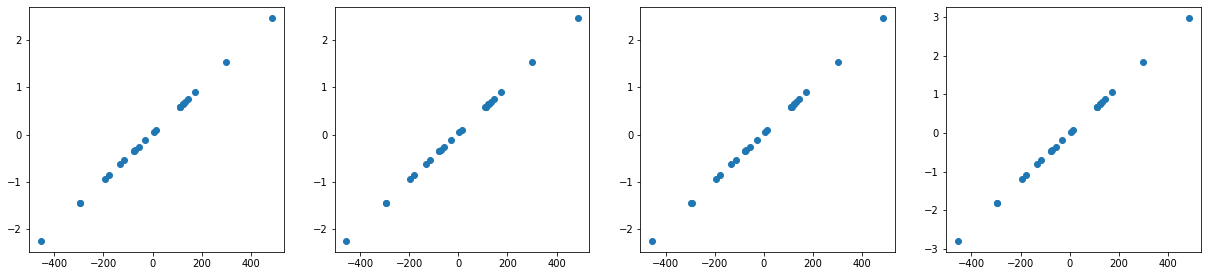

In [11]:
### Test

scaler = StandardScaler()
y_batch = Y[0:24]                                 # <- ez nagy hiba lenne mert az Y_trai[0] nem azonos Y[0:24] ugyanis az Y_train randomizált volt
y_batch = Y_train[0]                              # <- ha a fenti futással azonos eredményt akarok kapni akkor ezt az adatot kell használni
scaler.partial_fit(y_batch.reshape(-1, 1))
y_partialy_scaled = scaler.transform(y_batch.reshape(-1, 1))
y_partialy_scaled = y_partialy_scaled.flatten()
print(y_partialy_scaled)
print('pf min {:.5f}'.format(y_partialy_scaled.min()))
print('pf max  {:.5f}'.format(y_partialy_scaled.max()))
print('pf avg {:.5f}'.format(y_partialy_scaled.mean()))

scaler = StandardScaler()
y_batch = Y[0:24]                                 # <- ez nagy hiba lenne mert az Y_trai[0] nem azonos Y[0:24] ugyanis az Y_train randomizált volt
y_batch = Y_train[0]                              # <- ha a fenti futással azonos eredményt akarok kapni akkor ezt az adatot kell használni
scaler.fit(y_batch.reshape(-1, 1)) 
y_batch_scaled = scaler.transform(y_batch.reshape(-1, 1))
y_batch_scaled = y_batch_scaled.flatten()
print(y_batch_scaled)
print('pf min {:.5f}'.format(y_batch_scaled.min()))
print('pf max  {:.5f}'.format(y_batch_scaled.max()))
print('pf avg {:.5f}'.format(y_batch_scaled.mean()))

# Eddig tökéletesen az történik, amit elvárnék, hogy történnie keljen

scaler = StandardScaler()
y_batch_scaled_in_loop = []
for i in range(Y_train.shape[0]):
    y_batch = Y_train[i]
    scaler.partial_fit(y_batch.reshape(-1, 1))
    tmp = scaler.transform(y_batch.reshape(-1, 1))
    y_batch_scaled_in_loop.append(tmp)
y_batch_scaled_in_loop_part = y_batch_scaled_in_loop[0]
y_batch_scaled_in_loop_part = y_batch_scaled_in_loop_part.flatten()
print(y_batch_scaled_in_loop_part)
print('pf min {:.5f}'.format(y_batch_scaled_in_loop_part.min()))
print('pf max  {:.5f}'.format(y_batch_scaled_in_loop_part.max()))
print('pf avg {:.5f}'.format(y_batch_scaled_in_loop_part.mean()))   


print('--------------------------------')


scaler = StandardScaler()
y = Y                                             # <- az egészen tanítjuk
scaler.fit(y.reshape(-1, 1))
y = Y_train[0]                                    # <- de erre alkalmazzuk
y_scaled_whole = scaler.transform(y.reshape(-1, 1))
y_scaled_whole = y_scaled_whole.flatten()
print(y_scaled_whole)
print('pf min {:.5f}'.format(y_scaled_whole.min()))
print('pf max  {:.5f}'.format(y_scaled_whole.max()))
print('pf avg {:.5f}'.format(y_scaled_whole.mean()))

import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(21, 4.5))
ax0.scatter(Y_train[0], y_partialy_scaled)
ax1.scatter(Y_train[0], y_batch_scaled)
ax2.scatter(Y_train[0], y_batch_scaled_in_loop_part)
ax3.scatter(Y_train[0], y_scaled_whole)
plt.plot()


### Na azért nem egészen

Hasonítsuk össze azt, hogy kötegenként transzformálunk és elmentünk azzal, hogy kötegenként tanulunk majd az összes kötegen végig iterált model alapján csináljuk meg a transzfromációt.

(216000,)
[ 0.58883182 -1.4383527   1.52472023 -0.3521871  -0.54136387 -0.94286686
 -0.25404412  2.45641997  0.88991485 -0.63099441  0.58954721  0.10068942
  0.74642559 -0.8591424   0.64846659 -0.11788362 -0.35342804  0.63979301
 -1.44399805  0.57911385 -2.24431562  0.68939522  0.05342063 -0.32816159]
(216000,)
[ 0.68240152 -1.80220894  1.82946934 -0.47095449 -0.70281824 -1.19491873
 -0.35066595  2.97140332  1.05142271 -0.81267354  0.68327832  0.08411177
  0.87555567 -1.09230219  0.75549262 -0.18378139 -0.47247544  0.74486189
 -1.80912814  0.67049073 -2.79003411  0.80565664  0.02617697 -0.44150772]


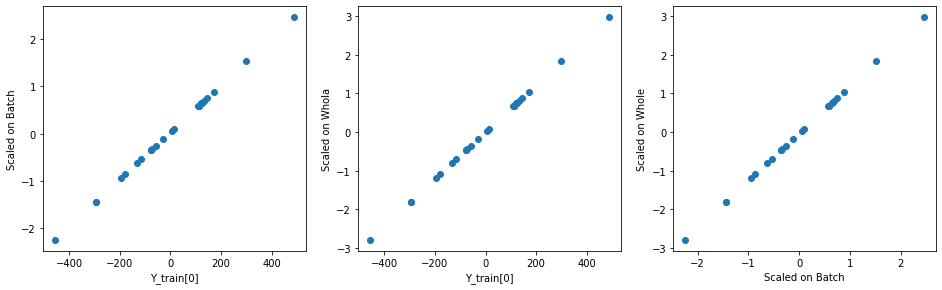

In [14]:
from sklearn.preprocessing import StandardScaler

### Scaling Data

scaler = StandardScaler()

y_batch_scaled_in_loop = []

for i in range(Y_train.shape[0]):
    y_batch = Y_train[i]
    scaler.partial_fit(y_batch.reshape(-1, 1))
    tmp = scaler.transform(y_batch.reshape(-1, 1))
    y_batch_scaled_in_loop.append(tmp)

y_scaled_type_1 = np.array(y_batch_scaled_in_loop).flatten()
print(y_scaled_type_1.shape)
print(y_scaled_type_1[0:24])

# --

# A feltanított scaler alapján újra skálázom az egészet

y_batch_tranformed_in_loop = []

for i in range(Y_train.shape[0]):
    y_batch = Y_train[i]
    # scaler.partial_fit(y_batch.reshape(-1, 1))        # <- nincs tanítás
    tmp = scaler.transform(y_batch.reshape(-1, 1))
    y_batch_tranformed_in_loop.append(tmp)

y_scaled_type_2 = np.array(y_batch_tranformed_in_loop).flatten()
print(y_scaled_type_2.shape)
print(y_scaled_type_2[0:24])

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4.5))
ax0.scatter(Y_train[0], y_scaled_type_1[0:24])
ax0.set_ylabel('Scaled on Batch')
ax0.set_xlabel('Y_train[0]')
ax1.scatter(Y_train[0], y_scaled_type_2[0:24])
ax1.set_ylabel('Scaled on Whola')
ax1.set_xlabel('Y_train[0]')
ax2.scatter(y_scaled_type_1[0:24], y_scaled_type_2[0:24])
ax2.set_ylabel('Scaled on Whole')
ax2.set_xlabel('Scaled on Batch')
plt.show()

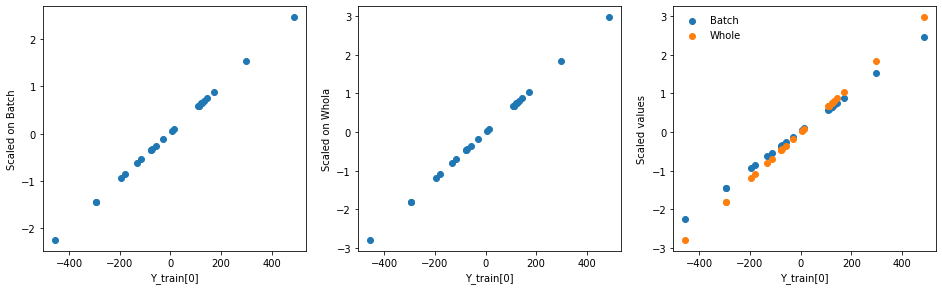

In [15]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4.5))
ax0.scatter(Y_train[0], y_scaled_type_1[0:24])
ax0.set_ylabel('Scaled on Batch')
ax0.set_xlabel('Y_train[0]')
ax1.scatter(Y_train[0], y_scaled_type_2[0:24])
ax1.set_ylabel('Scaled on Whola')
ax1.set_xlabel('Y_train[0]')
ax2.scatter(Y_train[0], y_scaled_type_1[0:24], label = 'Batch')
ax2.scatter(Y_train[0], y_scaled_type_2[0:24], label = 'Whole')
ax2.set_ylabel('Scaled values')
ax2.set_xlabel('Y_train[0]')
ax2.legend(frameon=False)
plt.show()

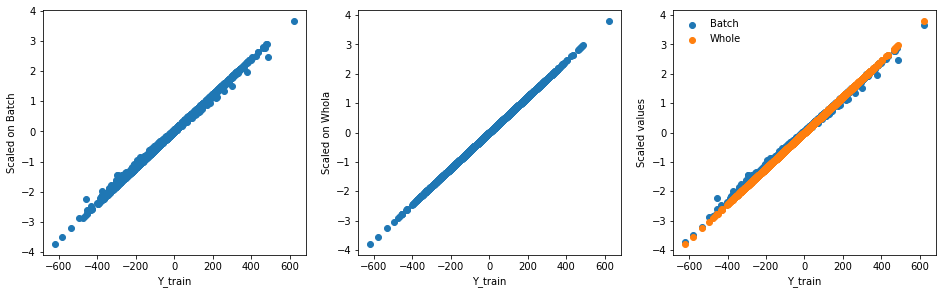

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 4.5))
ax0.scatter(Y_train[0:100], y_scaled_type_1[0:2400])
ax0.set_ylabel('Scaled on Batch')
ax0.set_xlabel('Y_train')
ax1.scatter(Y_train[0:100], y_scaled_type_2[0:2400])
ax1.set_ylabel('Scaled on Whola')
ax1.set_xlabel('Y_train')
ax2.scatter(Y_train[0:100], y_scaled_type_1[0:2400], label = 'Batch')
ax2.scatter(Y_train[0:100], y_scaled_type_2[0:2400], label = 'Whole')
ax2.set_ylabel('Scaled values')
ax2.set_xlabel('Y_train')
ax2.legend(frameon=False)
plt.show()

### Észrevétel

Itt azért kijönt a két módszer közötti különbség - amikor több köteget vizsgálunk.

### Következtetés

A normalizációt **nem szabad** kötegenként megcsinálni.

Használat:


```
# Használat

for i in range(Y_train.shape[0]):
    y_batch = Y_train[i]
    scaler.partial_fit(y_batch.reshape(-1, 1))

# --

# A feltanított scaler alapján kell skálázom az egészet

# Mivel batchenként tanítottam itt is iterálni kell

y_scaled = []

for i in range(Y_train.shape[0]):
    y_batch = Y_train[i]
    # scaler.partial_fit(y_batch.reshape(-1, 1))        # <- nincs tanítás
    tmp = scaler.transform(y_batch.reshape(-1, 1))      # >- csak transformáció
    y_scaled.append(tmp)
```



### Using the scaler inside the iteration

After the scaling estimator is trained, we have created an instance of SGDRegressor which we'll use for training scaled data. We are then looping through the dataset in batches taking a single batch at a time, scaling it with a scaling estimator, and training the regressor on scaled batch data using partial_fit() method.

In [25]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

### Scaling Data

scaler = StandardScaler()

for i in range(X_train.shape[0]):
    X_batch, Y_batch = X_train[i], Y_train[i]
    scaler.partial_fit(X_batch, Y_batch) ## Partially fitting data in batches


### Fitting Data in batches

regressor = SGDRegressor()

epochs = 10

for k in range(epochs):
    for i in range(X_train.shape[0]):
        X_batch, Y_batch = X_train[i], Y_train[i]
        X_batch = scaler.transform(X_batch) ## Preprocessing Single batch of data
        regressor.partial_fit(X_batch, Y_batch) ## Partially fitting data in batches


### Calculate Prediction

Y_test_preds = []

for i in range(X_test.shape[0]):
  X_batch_scaled = scaler.transform(X_test[i]) ## Preprocessing Single batch of data
  Y_pred = regressor.predict(X_batch_scaled)
  Y_test_preds.extend(Y_pred.tolist())

### Calculate Error

from sklearn.metrics import mean_squared_error, r2_score

print("Test MSE      : {}".format(mean_squared_error(Y_test.reshape(-1), Y_test_preds)))
print("Test R2 Score : {}".format(r2_score(Y_test.reshape(-1), Y_test_preds)))


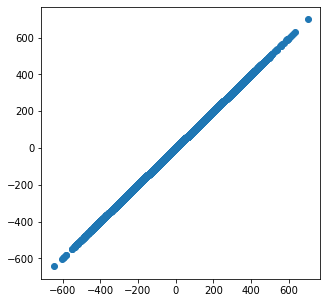

In [32]:
plt.figure(figsize=(5, 5))
plt.scatter(Y_test.reshape(-1), Y_test_preds)
plt.show()

### A fent leírtak példájára így néz ki egy teljes tanítási ciklus normalizációval



```
# JoDeMiro what else?
```

